# Предсказание стоимости жилья

**Цель работы** — спрогнозировать медианную стоимость дома в жилых массивах Калифорнии за 1990 год.

Работа будет выполнена с помощью API из среды **Spark — MLlib**.

В имеющемся датасете содержатся следующие данные о жилых массивах:
* longitude — широта
* latitude — долгота
* housing_median_age — медианный возраст жителей
* total_rooms — общее количество комнат в домах
* total_bedrooms — общее количество спален в домах
* population — количество проживающих человек
* households — количество домовладений
* median_income  — медианный доход жителей
* ocean_proximity — близость к океану
* median_house_value — целевой признак, медианная стоимость дома

**Ход работы**

Инициализируем Spark-сессию, прочитаем содержимое файла с датасетом и взглянем на его типы данных.

Потом при необходимости выполним предобработку данных, после чего построим две модели на разных наборах данных — используя все данные из файла и используя только числовые переменные. Подберём гиперпараметры с помошью кросс-валидации.

В итоге сравним результаты работы двух моделей по метрикам RMSE, MAE и R2, сформулируем общий вывод.
 
Таким образом, вся работа займёт пять этапов:

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Ознакомление-с-данными" data-toc-modified-id="Ознакомление-с-данными-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Ознакомление с данными</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Генерация-новых-числовых-признаков" data-toc-modified-id="Генерация-новых-числовых-признаков-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Генерация новых числовых признаков</a></span></li><li><span><a href="#Исследовательский-анализ" data-toc-modified-id="Исследовательский-анализ-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Исследовательский анализ</a></span></li><li><span><a href="#Удаление-выбросов-и-генерация-категориальных-признаков" data-toc-modified-id="Удаление-выбросов-и-генерация-категориальных-признаков-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Удаление выбросов и генерация категориальных признаков</a></span></li><li><span><a href="#Обработка-пропусков" data-toc-modified-id="Обработка-пропусков-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Обработка пропусков</a></span></li><li><span><a href="#Кодирование-категориальных-признаков" data-toc-modified-id="Кодирование-категориальных-признаков-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Кодирование категориальных признаков</a></span></li><li><span><a href="#Деление-данных-на-выборки-и-масштабирование-числовых-признаков" data-toc-modified-id="Деление-данных-на-выборки-и-масштабирование-числовых-признаков-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Деление данных на выборки и масштабирование числовых признаков</a></span></li></ul></li><li><span><a href="#Разработка-моделей" data-toc-modified-id="Разработка-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Разработка моделей</a></span><ul class="toc-item"><li><span><a href="#Создание-общего-вектора-со-всеми-признаками" data-toc-modified-id="Создание-общего-вектора-со-всеми-признаками-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание общего вектора со всеми признаками</a></span></li><li><span><a href="#Обучение-моделей-и-формирование-предсказаний" data-toc-modified-id="Обучение-моделей-и-формирование-предсказаний-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей и формирование предсказаний</a></span></li></ul></li><li><span><a href="#Сравнение-качества-моделей" data-toc-modified-id="Сравнение-качества-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Сравнение качества моделей</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></div>

## Ознакомление с данными

Изучим предоставленные данные.

In [1]:
import pandas as pd
from itertools import product

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import \
    StringIndexer, \
    OneHotEncoder, \
    Bucketizer, \
    VectorAssembler, \
    StandardScaler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
        
RANDOM_SEED = 9339

In [2]:
# инициализация сессии и чтение файла
spark = SparkSession.builder \
    .master('local') \
    .appName('House value prediction') \
    .getOrCreate()

housing_estates = spark.read.load(
    'housing.csv', 
    format='csv',
    sep=',',
    inferSchema=True,
    header=True
    )

display(
    housing_estates.sample(.00075, RANDOM_SEED).show(),
    housing_estates.printSchema(),
    housing_estates.describe().toPandas().T
    )

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.04|   37.66|              10.0|     2031.0|         357.0|     867.0|     352.0|       5.3169|          299200.0|       NEAR BAY|
|  -122.11|   37.67|              32.0|     3028.0|         811.0|    2037.0|     703.0|       3.0645|          165400.0|       NEAR BAY|
|  -120.79|   38.54|              34.0|     1133.0|         254.0|     495.0|     187.0|         2.05|           68900.0|         INLAND|
|  -122.29|   37.97|              20.0|     3426.0|         632.0|    1512.0|     580.0|       4.4911|          227400.0|       NEAR BAY|
|  -115.52|   33.12|              

None

None

,0,1,2,3,4
summary,count,mean,stddev,min,max
longitude,20640,-119.56970445736148,2.003531723502584,-124.35,-114.31
latitude,20640,35.6318614341087,2.135952397457101,32.54,41.95
housing_median_age,20640,28.639486434108527,12.58555761211163,1.0,52.0
total_rooms,20640,2635.7630813953488,2181.6152515827944,2.0,39320.0
total_bedrooms,20433,537.8705525375618,421.38507007403115,1.0,6445.0
population,20640,1425.4767441860465,1132.46212176534,3.0,35682.0
households,20640,499.5396802325581,382.3297528316098,1.0,6082.0
median_income,20640,3.8706710029070246,1.899821717945263,0.4999,15.0001
median_house_value,20640,206855.81690891474,115395.61587441359,14999.0,500001.0


**Промежуточные выводы**

По итогам обзора данных стоит совершить следующие изменения датасета на этапе предобработки:
1. Сгенерировать несколько новых фичей для обучения моделей
2. Разобраться с пропущенными значениями в колонке с количеством спален
4. Трансформировать категориальный признак с помощью "горячего" кодирования
5. Масштабировать числовые признаки

## Предобработка данных

Для начала проверим данные на дубликаты.

In [3]:
housing_estates = housing_estates.dropDuplicates()

housing_estates.describe().toPandas().T[0]

summary               count
longitude             20640
latitude              20640
housing_median_age    20640
total_rooms           20640
total_bedrooms        20433
population            20640
households            20640
median_income         20640
median_house_value    20640
ocean_proximity       20640
Name: 0, dtype: object

Изменений не произошло, дубликатов не найдено.

### Генерация новых числовых признаков

Создадим три новых признака: среднее количество комнат в домовладении, среднее количество спален на одну комнату, среднее число проживающих в домовладении. 

In [4]:
housing_estates = housing_estates.withColumn(
    'avg_rooms_per_hh',
    F.col('total_rooms') / F.col('households')
    )
housing_estates = housing_estates.withColumn(
    'bedrooms_per_room',
    F.col('total_bedrooms') / F.col('total_rooms')
    )
housing_estates = housing_estates.withColumn(
    'population_in_hh',
    F.col('population') / F.col('households')
    )
housing_estates.sample(.00075, RANDOM_SEED).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+------------------+-------------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|  avg_rooms_per_hh|  bedrooms_per_room|  population_in_hh|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+------------------+-------------------+------------------+
|  -122.13|   40.01|              21.0|      916.0|         194.0|     451.0|     178.0|        2.125|           63300.0|         INLAND| 5.146067415730337|0.21179039301310043| 2.533707865168539|
|  -117.47|   34.12|               6.0|    10565.0|        1767.0|    5690.0|    1555.0|       4.1797|          141000.0|         INLAND| 6.794212218649518|0.16725035494557502|3.6591639871382635|
|  -116.35|   32.74|

### Исследовательский анализ

Прежде чем переходить к обработке пропусков, рассмотрим более подробно особенности распределений имеющихся признаков, также обработаем данные на основе этого анализа.

In [5]:
# просмотр значений категориального признака
housing_estates.groupBy('ocean_proximity').count().orderBy('count').toPandas()

,ocean_proximity,count
0,ISLAND,5
1,NEAR BAY,2290
2,NEAR OCEAN,2658
3,INLAND,6551
4,<1H OCEAN,9136


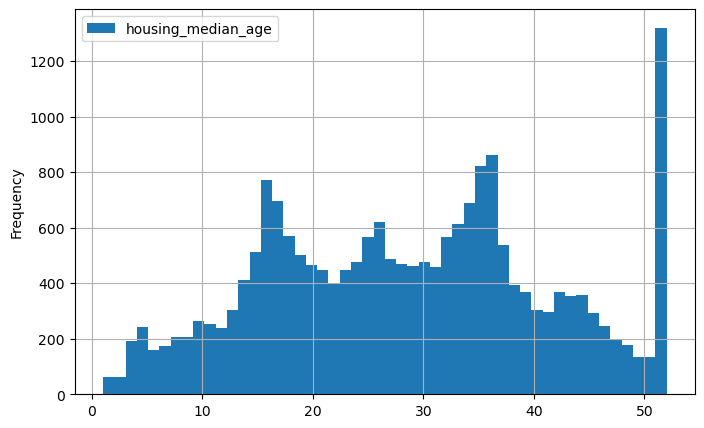

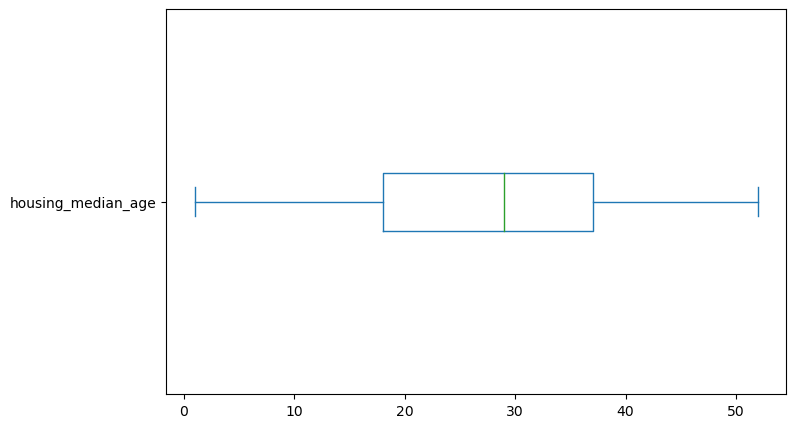

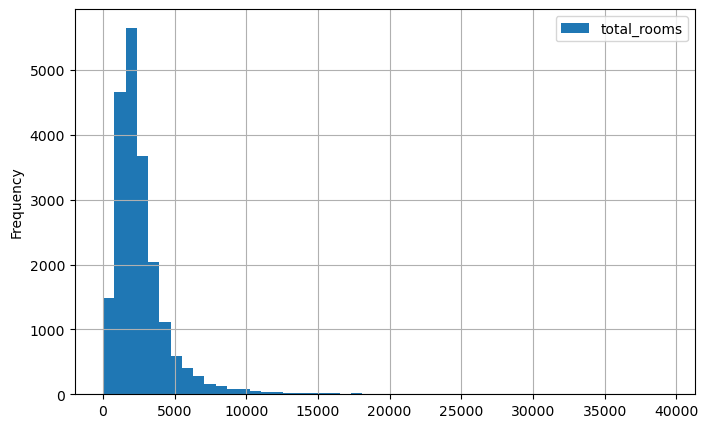

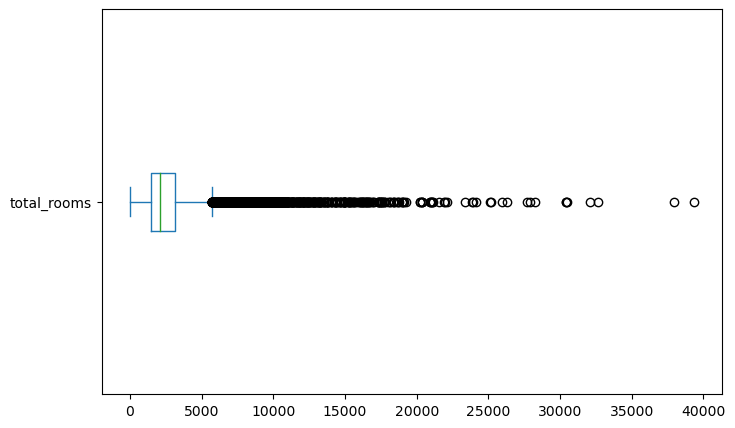

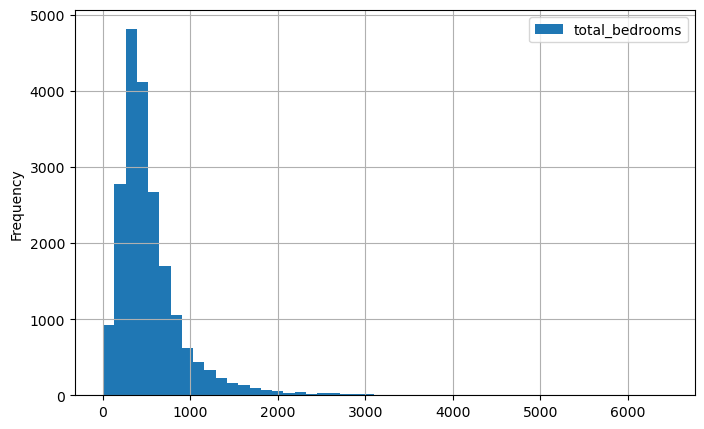

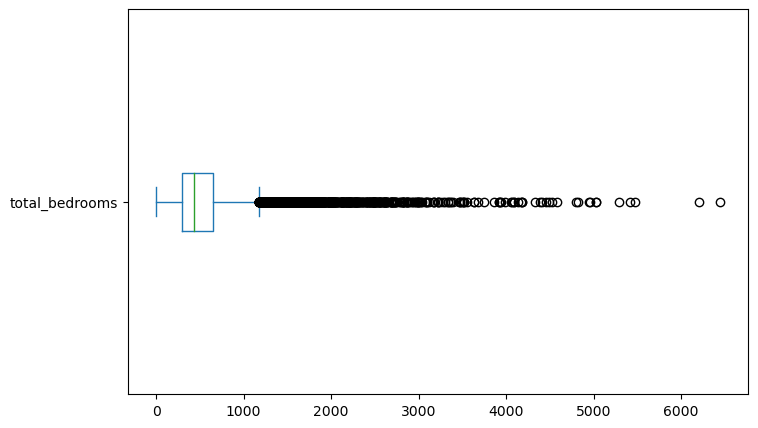

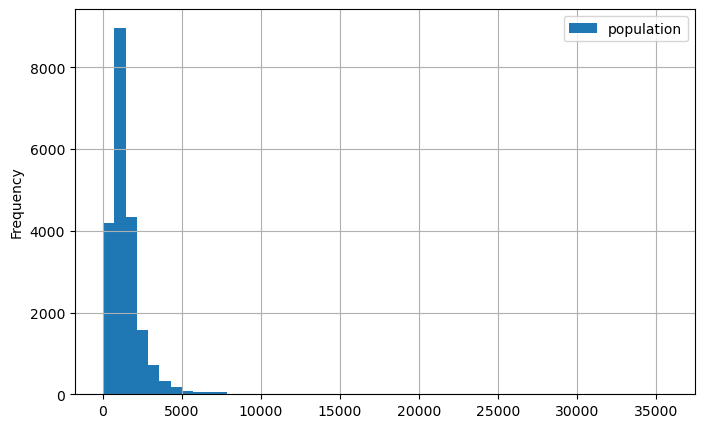

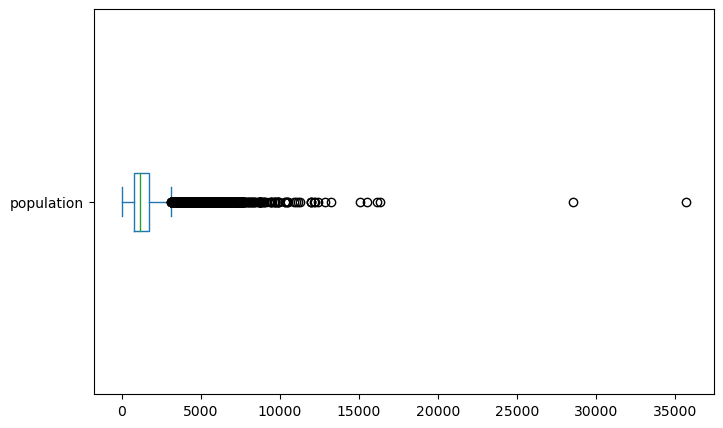

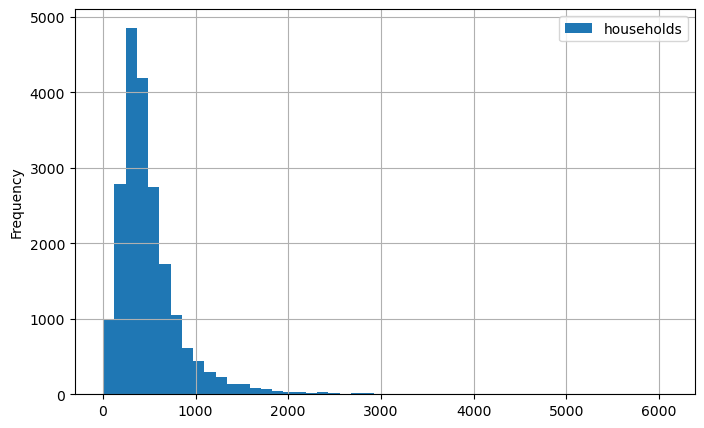

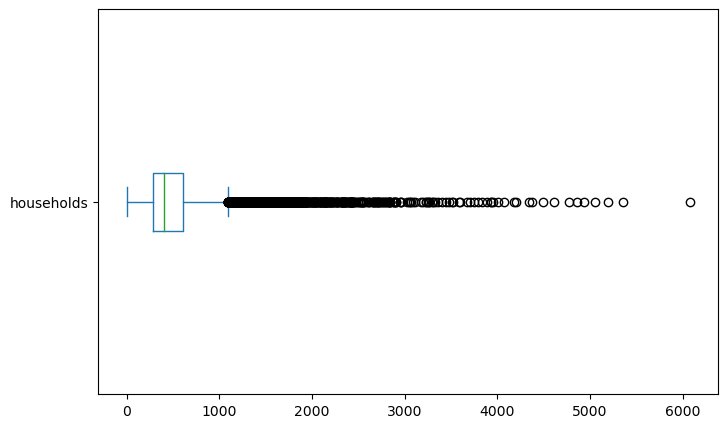

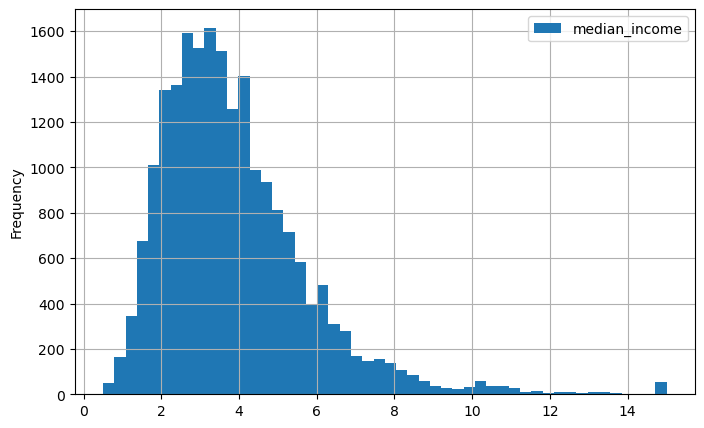

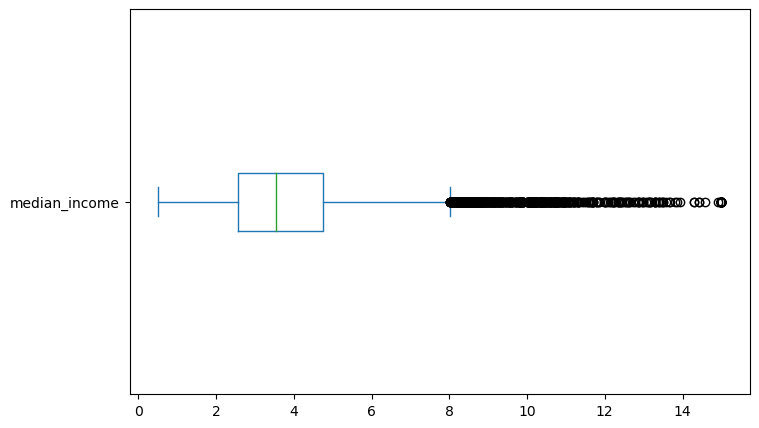

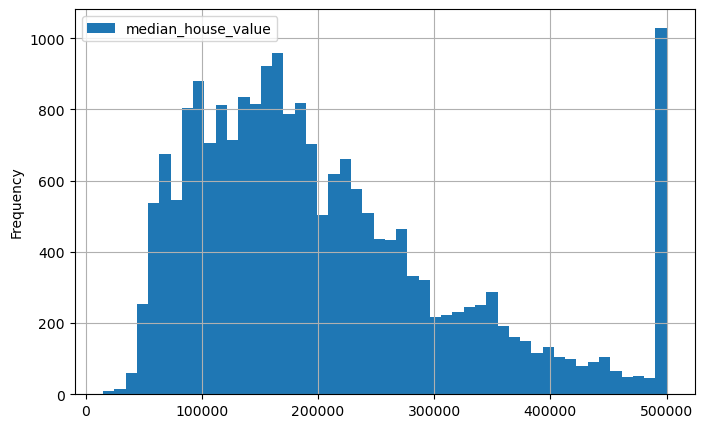

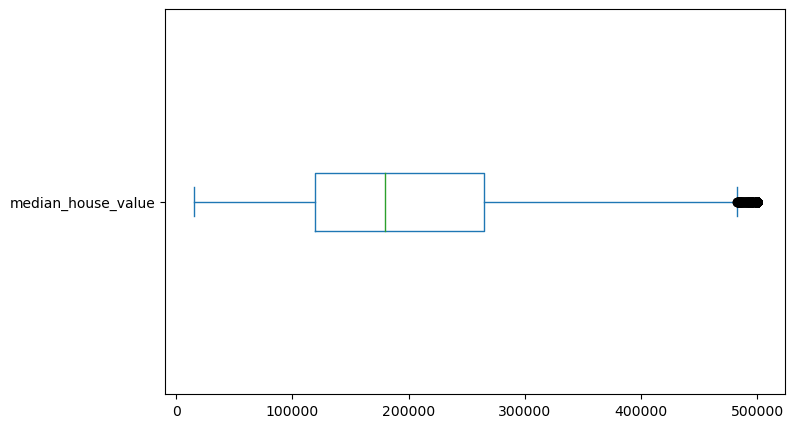

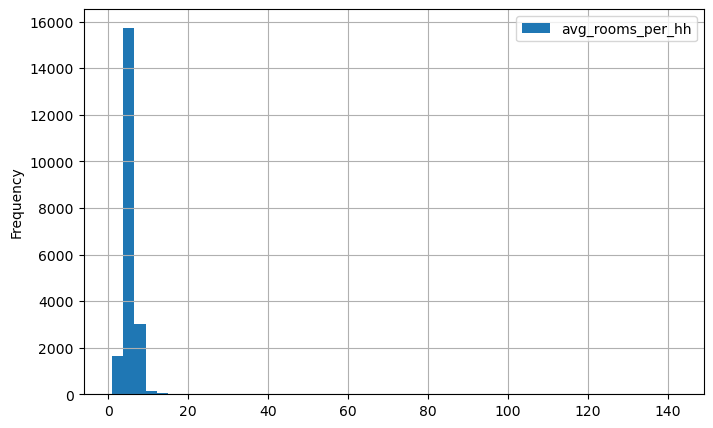

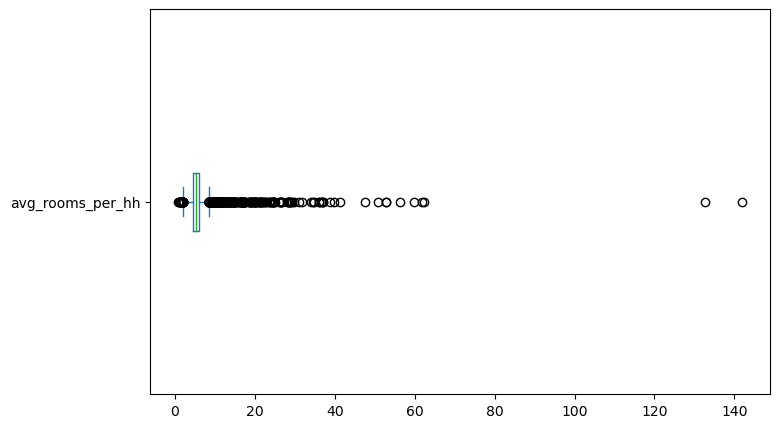

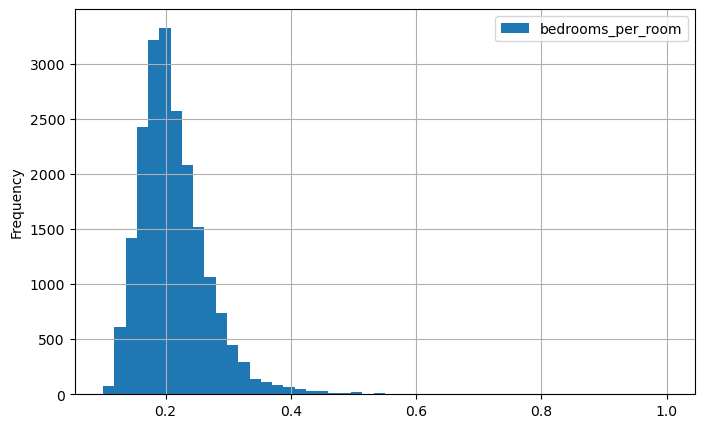

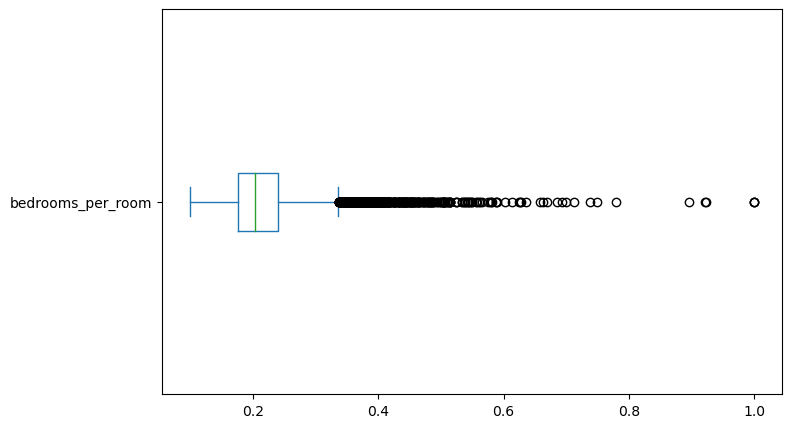

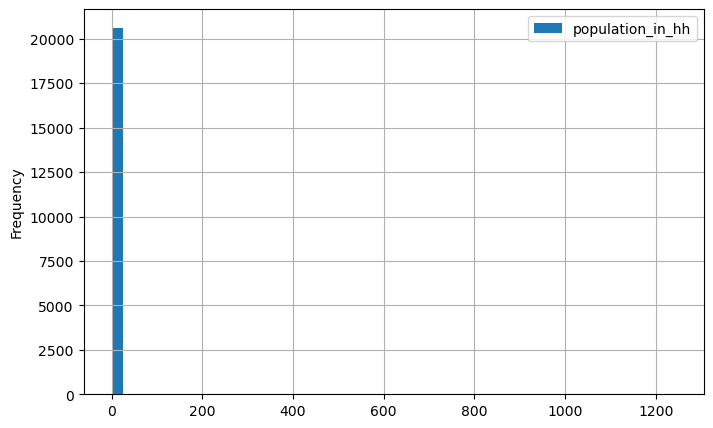

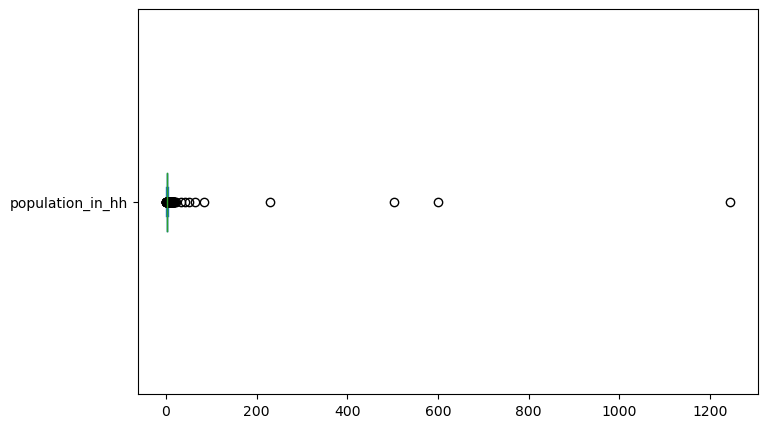

In [6]:
numeric_cols = [
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value',
    'avg_rooms_per_hh',
    'bedrooms_per_room',
    'population_in_hh'
    ]
def distribution_num_features(df, feats):
    for feat in feats:
        df.select(feat).toPandas().plot.hist(
            bins=50,
            grid=True,
            figsize=[8, 5]
            )
        df.select(feat).toPandas().plot.box(
            legend=False,
            figsize=[8, 5],
            vert=False
            )
distribution_num_features(housing_estates, numeric_cols)

На основании полученных распределений сделаем определённые преобразования с датасетом:
* При условии их небольшой доли от общего количества записей удалим выбросы в следующих колонках:
  * `total_rooms`
  * `total_bedrooms`
  * `population`
  * `households`
* На основании следующих колонок создадим дополнительные категориальные признаки:
  * `housing_median_age`
  * `median_income`

В последних, а также в колонке с целевым признаком **median_house_value** выбросы удалять не будем, так как во-первых, их доля достаточно высока, во-вторых, это изначально медианные значения, следовательно, вероятность их достоверности выше, в-третьих, для всех них характерно наибольшее количество выбросов именно с одним максимальным значением, что может говорить о том, что при составлении данных всем массивам с соответствующими значениями выше максимальных также присваивалось это максимальное значение.

Новый признак на основании целевого создавать не будем, так как это может повлечь за собой утечку данных.

### Удаление выбросов и генерация категориальных признаков

In [7]:
# проверка доли выбросов
housing_estates.filter(
    (F.col('total_rooms')>5695) \
    | (F.col('total_bedrooms')>1173) \
    | (F.col('population')>3132) \
    | (F.col('households')>1092)
    ).count() / housing_estates.count()

0.09001937984496124

In [8]:
# удаление выбросов
housing_estates = housing_estates.filter(
    (F.col('total_rooms')<=5695) \
    | (F.col('total_bedrooms')<=1173) \
    | (F.col('population')<=3132) \
    | (F.col('households')<=1092)
    )
# формирование категориальных фичей
bucketizer = Bucketizer(
    splitsArray=[
        [-float("inf"), 14, 21, 38, float("inf")],
        [-float("inf"), 2.564, 4.744, 8.014, float("inf")]
        ],
    inputCols=['housing_median_age', 'median_income'],
    outputCols=['bucketed_housing_median_age', 'bucketed_median_income']
    )
housing_estates = bucketizer.transform(housing_estates)

housing_estates.sample(.00075, RANDOM_SEED).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+------------------+-------------------+------------------+---------------------------+----------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|  avg_rooms_per_hh|  bedrooms_per_room|  population_in_hh|bucketed_housing_median_age|bucketed_median_income|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+------------------+-------------------+------------------+---------------------------+----------------------+
|  -117.08|   34.96|              28.0|     1777.0|         307.0|     721.0|     259.0|       3.6343|           79800.0|         INLAND| 6.861003861003861|  0.172763083849184|2.7837837837837838|                        2.0|                   1.0|
|  -122.44| 

### Обработка пропусков

В одной из колонок с информацией о количестве спален есть пропуски. Взглянем на них подробнее и поймём, что лучше сделать.

In [9]:
display(
    housing_estates.filter(F.col('total_bedrooms').isNull())
    .toPandas().sample(10, random_state=RANDOM_SEED)
    )

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,avg_rooms_per_hh,bedrooms_per_room,population_in_hh,bucketed_housing_median_age,bucketed_median_income
128,-117.91,33.76,20.0,4413.0,NaN,4818.0,1063.0,2.8594,215100.0,<1H OCEAN,4.151458,NaN,4.532455,1.0,1.0
171,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY,6.102740,NaN,2.630137,3.0,2.0
24,-122.39,37.59,32.0,4497.0,NaN,1846.0,715.0,6.1323,500001.0,NEAR OCEAN,6.289510,NaN,2.581818,2.0,2.0
114,-120.98,37.60,36.0,1437.0,NaN,1073.0,320.0,2.1779,58400.0,INLAND,4.490625,NaN,3.353125,2.0,0.0
12,-117.65,34.04,15.0,3393.0,NaN,2039.0,611.0,3.9336,151000.0,INLAND,5.553191,NaN,3.337152,1.0,1.0
5,-118.08,33.92,38.0,1335.0,NaN,1011.0,269.0,3.6908,157500.0,<1H OCEAN,4.962825,NaN,3.758364,3.0,1.0
83,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN,6.163636,NaN,3.444444,1.0,2.0
134,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND,4.192201,NaN,3.877437,2.0,0.0
155,-118.12,34.08,35.0,2248.0,NaN,1762.0,622.0,3.0000,253900.0,<1H OCEAN,3.614148,NaN,2.832797,2.0,1.0
102,-120.85,37.78,25.0,421.0,NaN,303.0,106.0,2.2679,71300.0,INLAND,3.971698,NaN,2.858491,2.0,0.0


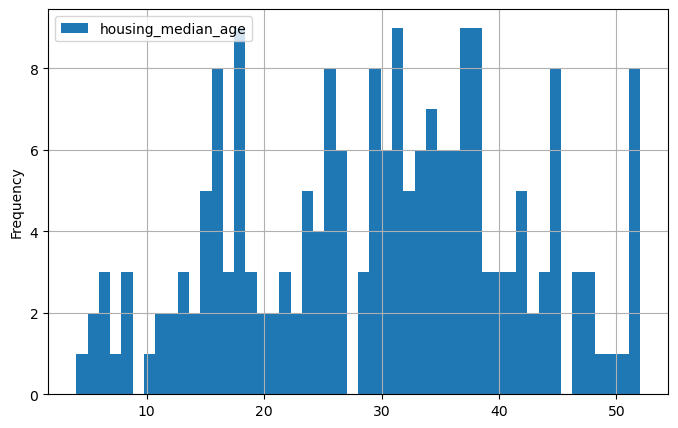

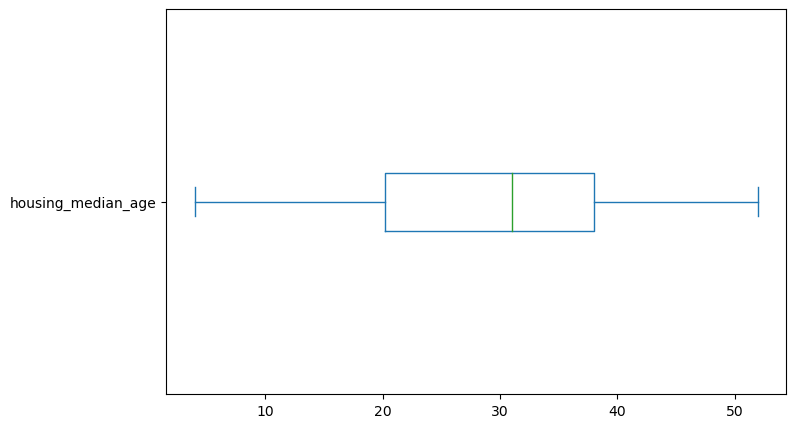

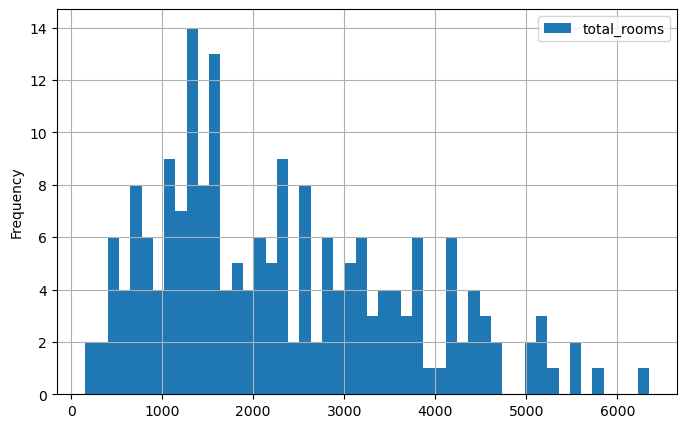

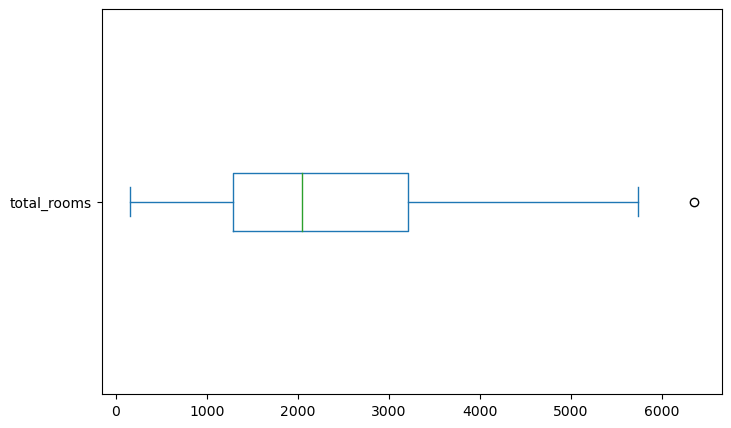

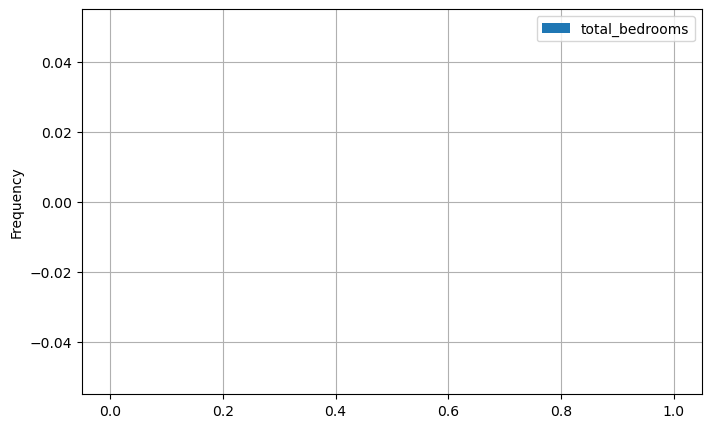

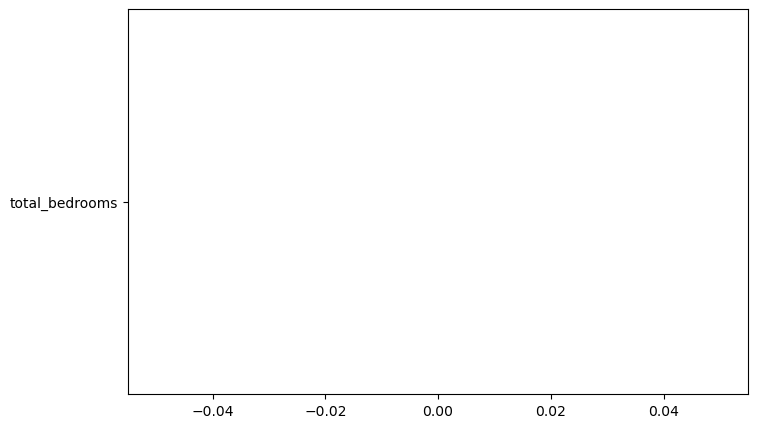

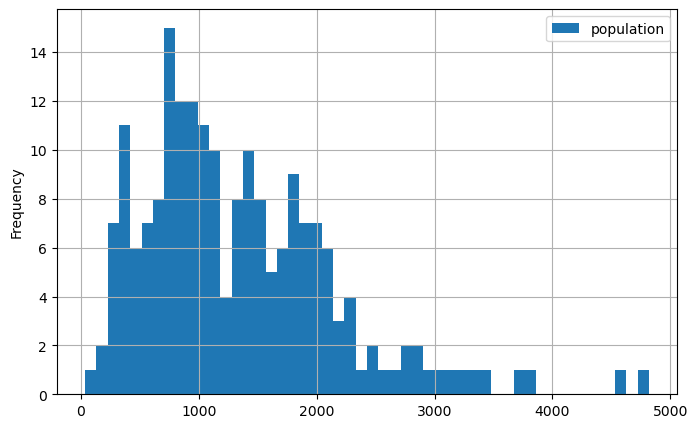

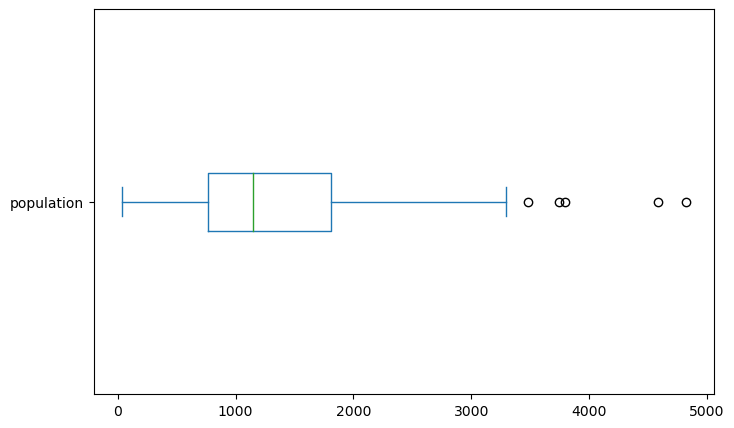

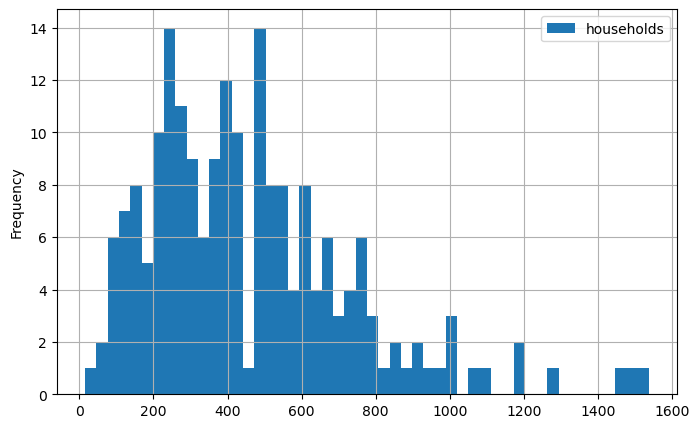

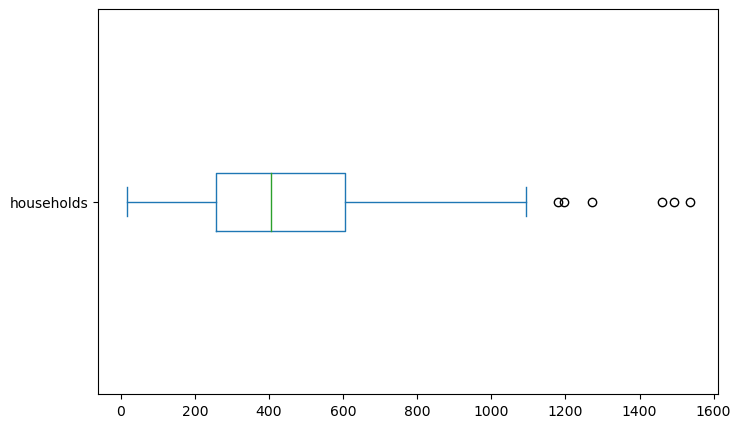

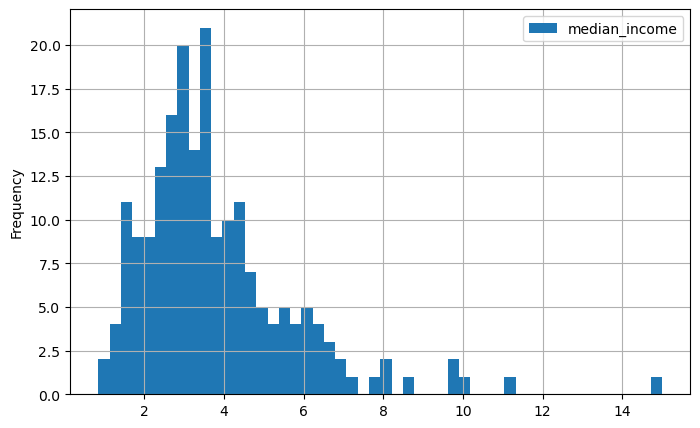

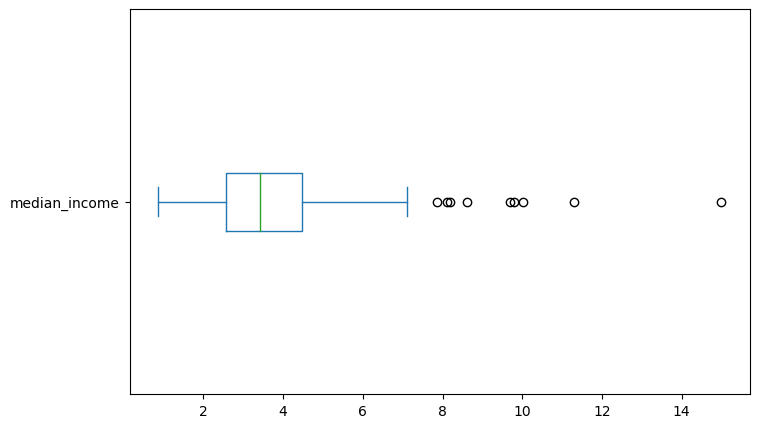

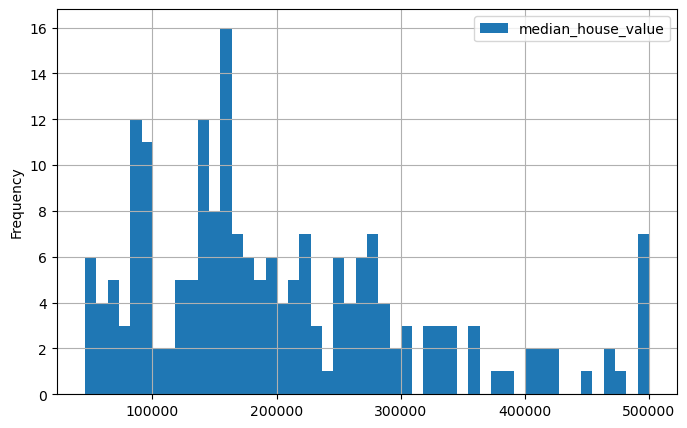

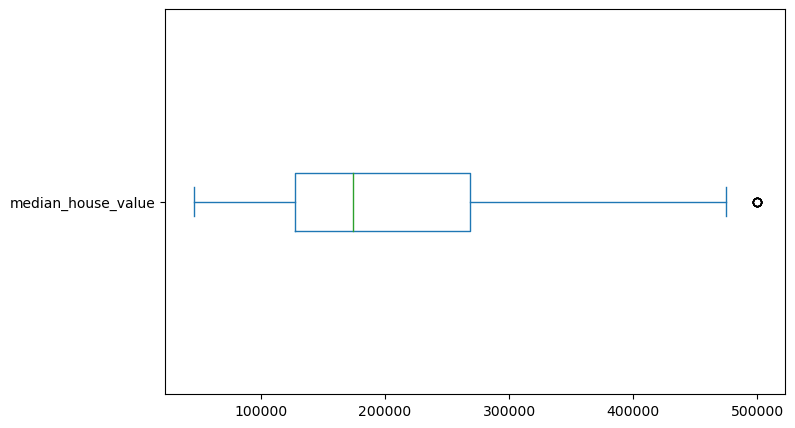

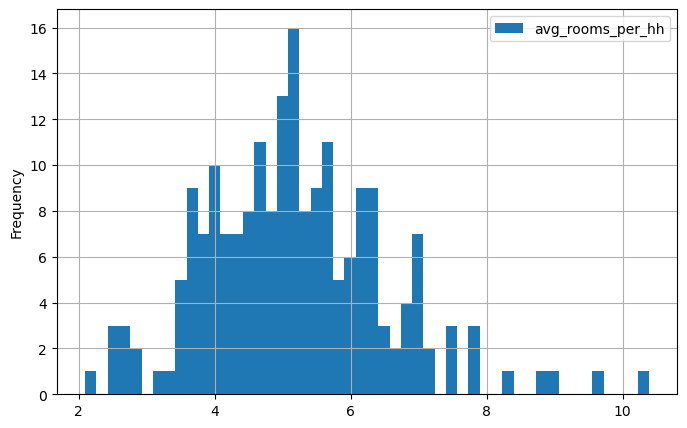

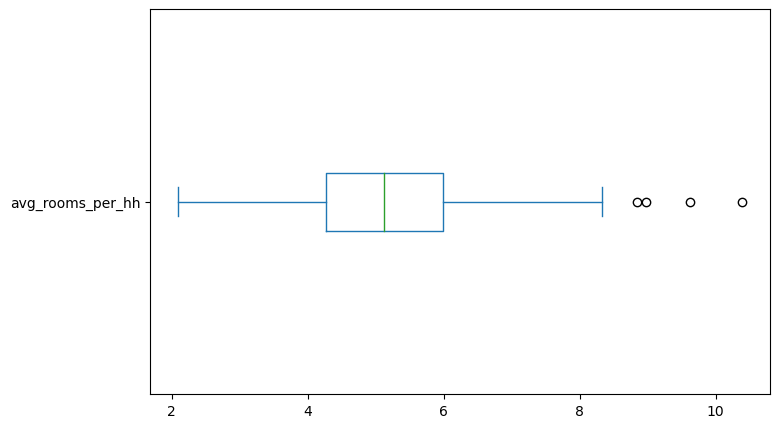

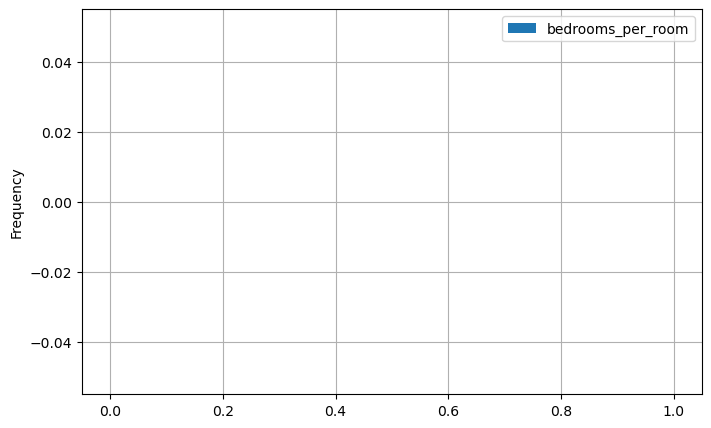

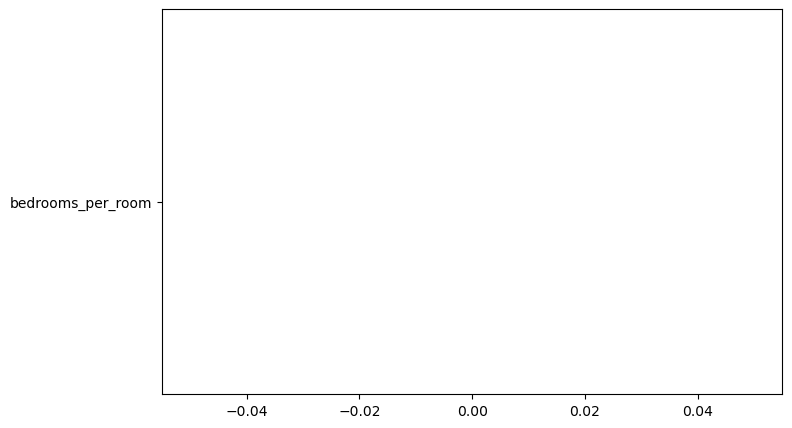

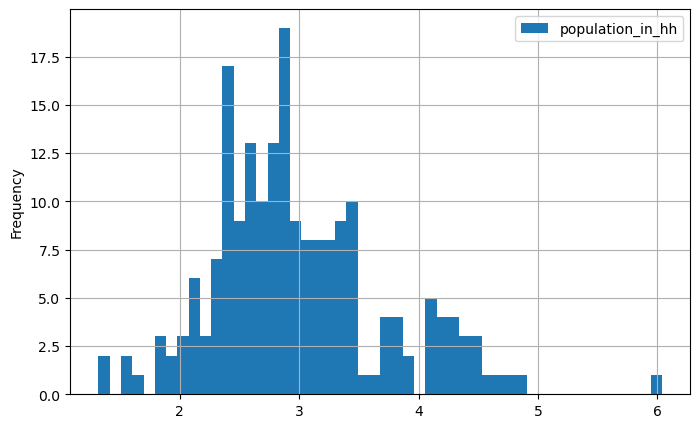

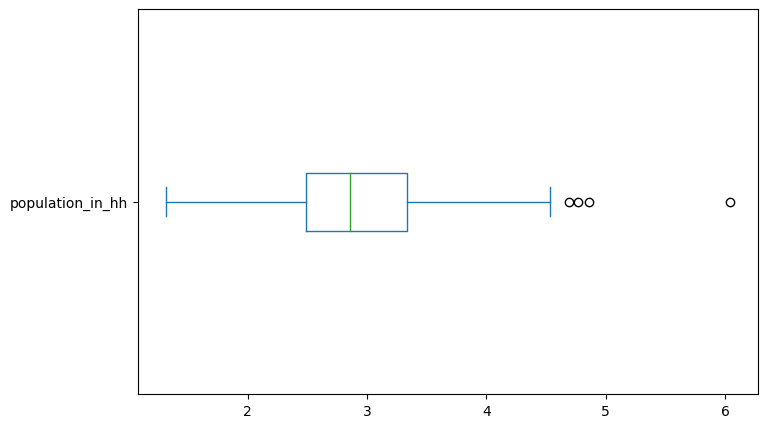

In [10]:
# получение распределений числовых значений в записях с пропусками
distribution_num_features(
    housing_estates.filter(F.col('total_bedrooms').isNull()),
    numeric_cols
    )

In [11]:
# получение распределений категориальных значений в записях с пропусками
with pd.option_context('display.max_rows', None):
    display(housing_estates.groupBy(
        'ocean_proximity',
        'bucketed_housing_median_age',
        'bucketed_median_income'
        ).count().orderBy('count', ascending=False).toPandas())

,ocean_proximity,bucketed_housing_median_age,bucketed_median_income,count
0,<1H OCEAN,2.0,1.0,2324
1,INLAND,2.0,1.0,1325
2,<1H OCEAN,2.0,2.0,1313
3,INLAND,2.0,0.0,1102
4,<1H OCEAN,3.0,1.0,1098
5,INLAND,1.0,1.0,807
6,<1H OCEAN,2.0,0.0,762
7,NEAR BAY,3.0,1.0,681
8,NEAR OCEAN,2.0,1.0,663
9,<1H OCEAN,1.0,1.0,656


Явных закономерностей в данных с пропусками не обнаружено. При условии их малой доли от всех данных удалим пропущенные значения.

In [12]:
# проверка доли пропусков
housing_estates.filter(
    F.col('total_bedrooms').isNull()
    ).count() / housing_estates.count()

0.009950248756218905

In [13]:
housing_estates = housing_estates.na.drop()

housing_estates.describe().toPandas().T[0]

summary                        count
longitude                      19701
latitude                       19701
housing_median_age             19701
total_rooms                    19701
total_bedrooms                 19701
population                     19701
households                     19701
median_income                  19701
median_house_value             19701
ocean_proximity                19701
avg_rooms_per_hh               19701
bedrooms_per_room              19701
population_in_hh               19701
bucketed_housing_median_age    19701
bucketed_median_income         19701
Name: 0, dtype: object

### Деление данных на выборки

Разделим датасет на обучающую и тестовые выборки.

In [14]:
train_data, test_data = housing_estates.randomSplit(
    [.8,.2],
    seed=RANDOM_SEED
    )
# проверка долей
print(train_data.count(), test_data.count())

15745 3956


### Кодирование категориальных признаков

Закодируем изначальный и сгенерированные ранее категориальные признаки с помощью `One-hot encoding`.

In [15]:
indexer = StringIndexer(
    inputCol='ocean_proximity', 
    outputCol='ocean_proximity_ind',
    handleInvalid='keep'
    ) 
indexer = indexer.fit(train_data)
train_data = indexer.transform(train_data)
test_data = indexer.transform(test_data)

categorical_cols = [
    'ocean_proximity_ind',
    'bucketed_housing_median_age',
    'bucketed_median_income'
    ]
encoder = OneHotEncoder(
    inputCols=categorical_cols,
    outputCols=[col+'_ohe' for col in categorical_cols]
    )
encoder = encoder.fit(train_data)
train_data = encoder.transform(train_data)
test_data = encoder.transform(test_data)

train_data.sample(.0011, RANDOM_SEED).show()
test_data.sample(.0033, RANDOM_SEED).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----------------+-------------------+------------------+---------------------------+----------------------+-------------------+-----------------------+-------------------------------+--------------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity| avg_rooms_per_hh|  bedrooms_per_room|  population_in_hh|bucketed_housing_median_age|bucketed_median_income|ocean_proximity_ind|ocean_proximity_ind_ohe|bucketed_housing_median_age_ohe|bucketed_median_income_ohe|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----------------+-------------------+------------------+---------------------------+----------------------+-------------------+-----------------------+-------------

Объединим признаки в соответствующие векторы.

In [16]:
numerical_cols = [
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'avg_rooms_per_hh',
    'bedrooms_per_room',
    'population_in_hh'
    ]
categorical_assembler = VectorAssembler(
    inputCols=[col+'_ohe' for col in categorical_cols],
    outputCol='categorical_features'
    )
train_data = categorical_assembler.transform(train_data)
test_data = categorical_assembler.transform(test_data)

numerical_assembler = VectorAssembler(
    inputCols=numerical_cols,
    outputCol='numerical_features'
    )
train_data = numerical_assembler.transform(train_data)
test_data = numerical_assembler.transform(test_data)

train_data.sample(.0011, RANDOM_SEED).show()
test_data.sample(.0033, RANDOM_SEED).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----------------+-------------------+------------------+---------------------------+----------------------+-------------------+-----------------------+-------------------------------+--------------------------+--------------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity| avg_rooms_per_hh|  bedrooms_per_room|  population_in_hh|bucketed_housing_median_age|bucketed_median_income|ocean_proximity_ind|ocean_proximity_ind_ohe|bucketed_housing_median_age_ohe|bucketed_median_income_ohe|categorical_features|  numerical_features|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----------------+-------------------+------------------+------------------------

### Масштабирование числовых признаков

In [17]:
scaler = StandardScaler(
    inputCol='numerical_features',
    outputCol='numerical_features_scaled'
    )
scaler = scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

После обработки данные готовы для последующего формирования двух наборов — с категориальными признаками и без них.

## Разработка моделей

### Создание общего вектора со всеми признаками

Сформируем итоговый вектор для создания модели, обученной на всех признаках.

In [18]:
final_assembler = VectorAssembler(
    inputCols=['categorical_features', 'numerical_features_scaled'], 
    outputCol='all_features'
    ) 
train_data = final_assembler.transform(train_data)
test_data = final_assembler.transform(test_data)

train_data.sample(.0011, RANDOM_SEED).show()
test_data.sample(.0033, RANDOM_SEED).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+-----------------+-------------------+------------------+---------------------------+----------------------+-------------------+-----------------------+-------------------------------+--------------------------+--------------------+--------------------+-------------------------+--------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity| avg_rooms_per_hh|  bedrooms_per_room|  population_in_hh|bucketed_housing_median_age|bucketed_median_income|ocean_proximity_ind|ocean_proximity_ind_ohe|bucketed_housing_median_age_ohe|bucketed_median_income_ohe|categorical_features|  numerical_features|numerical_features_scaled|        all_features|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---

### Обучение моделей и формирование предсказаний

Подобрав гиперпараметры, обучим две отдельные модели на разных данных — только с числовыми признаками и со всеми имеющимися. Получим соответствующие предсказания.

In [19]:
%%time
general_gb = GBTRegressor(
    labelCol='median_house_value',
    featuresCol='all_features',
    seed=RANDOM_SEED,
    maxIter=50
    )
general_grid = ParamGridBuilder() \
    .addGrid(general_gb.maxDepth, range(5, 10)) \
    .addGrid(general_gb.featureSubsetStrategy, ['onethird', 'log2']) \
    .addGrid(general_gb.stepSize, [0.03, 0.1]) \
    .build()
general_validator = CrossValidator(
    estimator=general_gb,
    estimatorParamMaps=general_grid,
    evaluator=RegressionEvaluator(labelCol='median_house_value'),
    numFolds=3,
    parallelism=10,
    seed=RANDOM_SEED
    )
general_model = general_validator.fit(train_data)

CPU times: total: 12.7 s
Wall time: 23h 59min 26s


In [21]:
%%time
numerical_gb = GBTRegressor(
    labelCol='median_house_value',
    featuresCol='numerical_features_scaled',
    seed=RANDOM_SEED,
    maxIter=50
    )
numerical_grid = ParamGridBuilder() \
    .addGrid(numerical_gb.maxDepth, range(5, 10)) \
    .addGrid(numerical_gb.featureSubsetStrategy, ['onethird', 'log2']) \
    .addGrid(numerical_gb.stepSize, [0.03, 0.1]) \
    .build()
numerical_validator = CrossValidator(
    estimator=numerical_gb,
    estimatorParamMaps=numerical_grid,
    evaluator=RegressionEvaluator(labelCol='median_house_value'),
    numFolds=3,
    parallelism=10,
    seed=RANDOM_SEED
    )
numerical_model = numerical_validator.fit(train_data)

CPU times: total: 16 s
Wall time: 1d 6h 16min 27s


In [22]:
general_predictions = general_model.transform(test_data)
numerical_predictions = numerical_model.transform(test_data)

general_predictions.select(
    'median_house_value',
    'prediction'
    ).sample(.003, RANDOM_SEED).show()
numerical_predictions.select(
    'median_house_value',
    'prediction'
    ).sample(.003, RANDOM_SEED).show()

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          126500.0|136772.78015432594|
|          373400.0|257052.37257585296|
|          156100.0| 168794.6608608507|
|          166700.0| 176257.4782024675|
|           44500.0| 63960.10131613108|
|          500001.0| 471281.3524721842|
|          252000.0|277404.32334850903|
|          288900.0| 298184.0078655994|
|          118800.0|153591.13027453047|
|           98000.0|151137.00009329108|
|           98900.0|114184.01879935678|
+------------------+------------------+

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          126500.0| 164223.2154205018|
|          373400.0|  237900.670264636|
|          156100.0|145287.91330840404|
|          166700.0|160894.90617200822|
|           44500.0| 63467.18037814727|
|          500001.0|455881.93317599664|
|          252000.0|227770.43141756716|

## Сравнение качества моделей

Сравним качество полученных на разных данных моделей по трём метрикам: **RMSE**, **MAE** и **R2**.

In [23]:
types = ['general', 'numerical']
metrics = ['rmse', 'mae', 'r2']
results = pd.DataFrame(
    index=[type+'_model' for type in types],
    columns=metrics
    )
for type, metric in product(types, metrics):
    results.loc[type+'_model', metric] = RegressionEvaluator(
        labelCol='median_house_value',
        metricName=metric
        ).evaluate(locals().get(type+'_predictions'))
results.style.format('{:.3f}')

,rmse,mae,r2
general_model,60289.888,42922.207,0.724
numerical_model,67863.170,48683.334,0.650


In [24]:
spark.stop()

## Итоговый вывод

Лучшие результаты по всем трём метрикам показало обучение линейной модели на всех признаках, как числовых, так и категориальных. **RMSE** ожидаемо выше **MAE**, так как считает квадраты ошибок.